In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pymongo
import argparse
from configparser import ConfigParser
import os
import json

In [69]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans

## Connect to MongoDB

In [4]:
config = ConfigParser()
pardir = os.getcwd()
config.read('secrets.ini')
DB_USER = config['MONGODB']['CKIDS_USER']
DB_PASS = config['MONGODB']['CKIDS_PASS']
DB_NAME = config['MONGODB']['CKIDS_DB_NAME']
HOST = config['AWS']['HOST_IP']
PORT = config['AWS']['HOST_PORT']
client = pymongo.MongoClient("mongodb://{DB_USER}:{DB_PASS}@{HOST}:{PORT}/{DB_NAME}".format(
    DB_USER=DB_USER, DB_PASS=DB_PASS, HOST=HOST, PORT=PORT, DB_NAME=DB_NAME))
db = client[DB_NAME]
collection = db["raw_artifacts"]
result = collection.find()

In [5]:
objID_data = {}
for obj in result:
    description = obj['description']
#     if description != '':
#         description_data += [description]
    try:
        keywords = ' '.join(obj['keywords'])
    except KeyError:
        keywords = ''
        None
#     keywords_data += [keywords]    
    title = obj['title']
#     if title != '':
#         title_data += [title]
    objID_data[obj['_id']] = title+' '+description+' '+keywords

## Approach 1. cluster by pre-defined kw groups

1. manually group keywords into say 10 clusters
2. if a artifact has  one(or N tbd.) of the keyword in one of the clusters, then this artifact can be assigned in this cluster.(soft clustering)

## Approach 2. TFIDF + kmeans cluster  

### Process Text for Clustering

In [6]:
kw_csv = pd.read_csv('final_kw_list.csv', index_col=0)
term_list = list(kw_csv["Other_word_to_match"].str.split(', '))

In [107]:
corpus = list(objID_data.values())
vectorizer = TfidfVectorizer(vocabulary=[t[0] for t in term_list])
X = vectorizer.fit_transform(corpus)
print(X.shape)

(277810, 183)


###  Kmeans  Clustering

In [109]:
k = 20
km = KMeans(n_clusters=k, init='k-means++', tol=1e-3, max_iter=500)
km.fit(X)
pred = km.predict(X)

<BarContainer object of 20 artists>

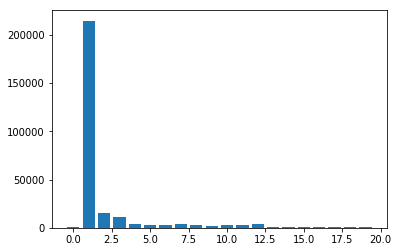

In [88]:
plt.bar(list(pd.value_counts(pred).index), list(pd.value_counts(pred)))

In [112]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: integrity privacy flood vulnerability exploit
Cluster 1: network key security virtualization vector
Cluster 2: key security network challenge integrity
Cluster 3: challenge key network security protection
Cluster 4: isolation key network robust reverse
Cluster 5: vector network key robust security
Cluster 6: security network key privacy authentication
Cluster 7: website network key exploit password
Cluster 8: protection security key network privacy
Cluster 9: robust network key challenge protection
Cluster 10: safe key protection challenge security
Cluster 11: virus key vector reverse protection
Cluster 12: perception key challenge network security
Cluster 13: patch key network robust isolation
Cluster 14: reverse key network challenge robust
Cluster 15: mitigation network key security challenge
Cluster 16: verification network authentication key security
Cluster 17: bug key patch website network
Cluster 18: leakage key network protection safe
Cluster 19: attack security net

In [91]:
l = [str(o) for o in objID_data.keys()]
relatedTo_clusters = dict(zip(l, list(str(p) for  p in pred)))

In [104]:
with open('RelatedTo_clusters.json', 'w') as f:
    json.dump(relatedTo_clusters, f)

In [105]:
with open('RelatedTo_clusters.json') as f:
    d = json.load(f)